# Configuration 



Dataset available on kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm.notebook import tqdm 

In [8]:
class CFG:
    
    epochs = 1                                         # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = "chest_xray"                       # Data Directory 
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cpu


# Image Transformation and Load Dataset 

In [3]:
from torchvision import transforms as T, datasets
from helper import show_image

In [4]:
train_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
valid_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path, transform=train_transform)
validset = datasets.ImageFolder(valid_path, transform=valid_transform)
testset = datasets.ImageFolder(test_path, transform=test_transform)

In [10]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


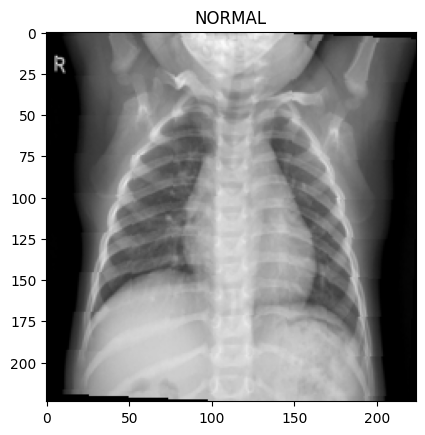

In [12]:
image, label = trainset[2]
class_name = ['NORMAL', 'PNEUMONIA']
show_image(image, class_name[label])

# Load Dataset into Batches 

In [29]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from helper import show_grid

In [15]:
trainloader = DataLoader(trainset, batch_size= CFG.batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size= CFG.batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size= CFG.batch_size, shuffle=True)

In [16]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of Total examples : {}".format(len(trainloader.dataset)))

No. of batches in trainloader : 326
No. of Total examples : 5216


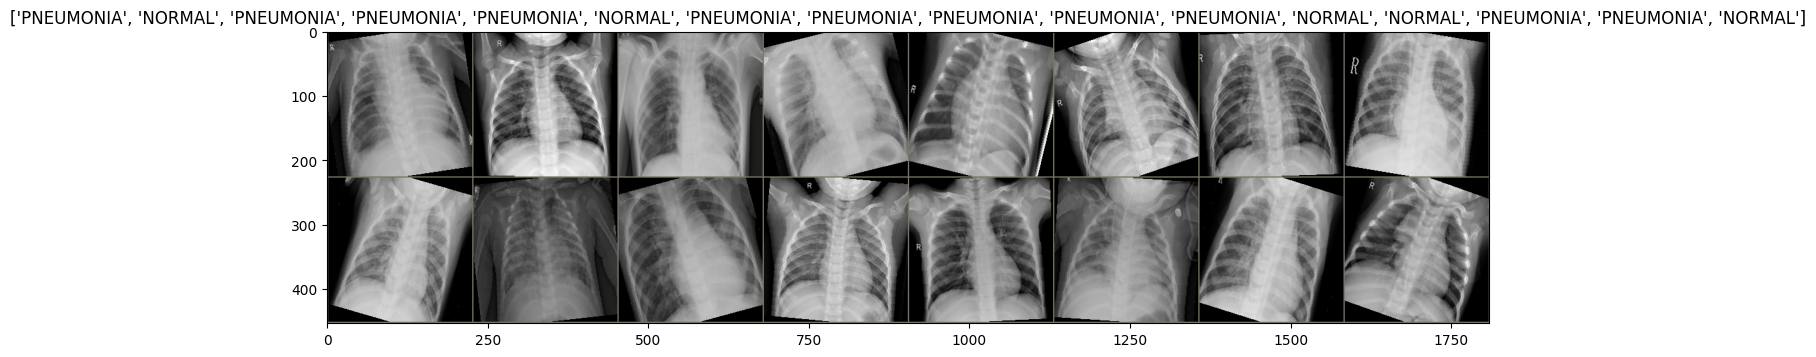

In [32]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

out = make_grid(images)
show_grid(image=out, title= [class_name[x] for x in labels])

# Fine Tuning EfficientNet Model 

In [38]:
from torch import nn 
import torch.nn.functional as F
import timm 

model = timm.create_model(CFG.model_name, pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2)
)

C:\Users\miguelestradam36\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


In [39]:
from torchsummary import summary 

summary(model,input_size=(3, 224, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 122]           1,296
          Identity-2         [-1, 48, 112, 122]               0
              SiLU-3         [-1, 48, 112, 122]               0
    BatchNormAct2d-4         [-1, 48, 112, 122]              96
            Conv2d-5         [-1, 48, 112, 122]             432
          Identity-6         [-1, 48, 112, 122]               0
              SiLU-7         [-1, 48, 112, 122]               0
    BatchNormAct2d-8         [-1, 48, 112, 122]              96
          Identity-9         [-1, 48, 112, 122]               0
           Conv2d-10             [-1, 12, 1, 1]             588
             SiLU-11             [-1, 12, 1, 1]               0
           Conv2d-12             [-1, 48, 1, 1]             624
          Sigmoid-13             [-1, 48, 1, 1]               0
    SqueezeExcite-14         [-1, 48, 1

# Build a Simple Trainer

In [41]:
from helper import accuracy
from tqdm import tqdm

In [46]:
class PneumoniaTrainer():
    
    def __init__(self, criterion, optimizer, schedular):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self, model, trainloader):
        train_acc = 0.0
        train_loss = 0.0
        for images, labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = self.criterion(logits, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(logits, labels)

        return train_acc / len(trainloader), train_loss / len(trainloader)

    
    def valid_batch_loop(self, model, validloader):
        valid_acc = 0.0
        valid_loss = 0.0
        for images, labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = self.criterion(logits, labels)

            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)

        return valid_acc / len(validloader), valid_loss / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs):
        model = model.to(device)
        valid_min_loss = np.inf
        for i in range(epochs):
            model.train() #turn on dropout
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)

            model.eval() #turn off dropout batch norm
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)

            if avg_valid_loss <= valid_min_loss:
                print("Valid loss decreased {}  ---> {}".format(valid_min_loss, avg_valid_loss))
                torch.save(model.state_dict(), 'PneumoniaModel.pt')
                valid_min_loss = avg_valid_loss
            print("Epoch: {} Train Loss: {} Train acc: {}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch: {} Valid Loss: {} Valid acc: {}".format(i+1, avg_valid_loss, avg_valid_acc))

# Training Model 


Trained on google colab : https://colab.research.google.com/drive/1C5nNPj7OLYMGnNvWBU5W2zSXfgWDdXCo?usp=sharing

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
schedular = None

trainer = PneumoniaTrainer(criterion, optimizer, schedular)
trainer.fit(model, trainloader, validloader, CFG.epochs)

  0%|          | 0/326 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Valid loss decreased inf  ---> 0.732362687587738
Epoch: 1 Train Loss: 0.2100645703652108 Train acc: 0.9175613522529602
Epoch: 1 Valid Loss: 0.732362687587738 Valid acc: 0.5


# Plot Results 

In [48]:
from helper import view_classify

model.load_state_dict(torch.load('PneumoniaModel.pt', map_location=device))
model.eval()
avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, testloader)

print("Test Loss : {}".format(avg_test_acc))
print("Test Acc : {}".format(avg_test_loss))

100%|██████████| 39/39 [01:48<00:00,  2.78s/it]

Test Loss : 0.8509615659713745
Test Acc : 0.3550497687015778


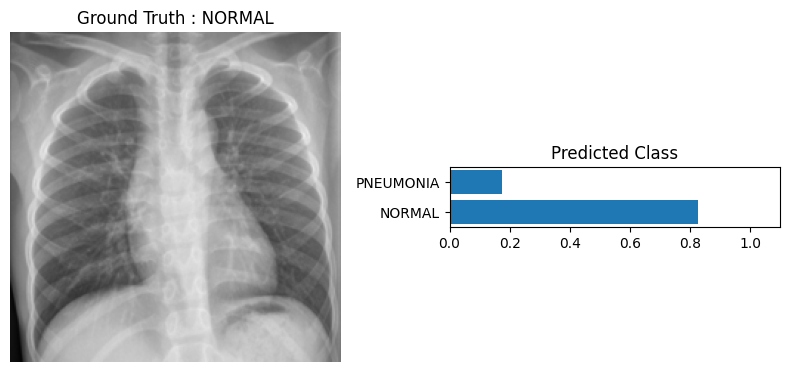

In [49]:
image,label = testset[3]

ps = model(image.unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)